In [8]:
pip install fastai duckduckgo-search

  Using cached fastai-2.8.2-py3-none-any.whl.metadata (9.5 kB)
  Using cached duckduckgo_search-8.1.0-py3-none-any.whl.metadata (16 kB)
  Using cached fastdownload-0.0.7-py3-none-any.whl.metadata (5.5 kB)
  Using cached fastcore-1.8.4-py3-none-any.whl.metadata (3.7 kB)
  Using cached fasttransform-0.0.2-py3-none-any.whl.metadata (7.6 kB)
  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached scipy-1.16.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached spacy-3.8.7-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached plum_dispatch-2.5.7-py3-none-any.whl.metadata (7.5 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached primp-0.15.


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from duckduckgo_search import DDGS
from fastcore.all import *

In [10]:
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [11]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 4090


In [14]:
urls = search_images("2020 Porsche 911 Photos", max_images=1)
urls[0]

'https://www.motortrend.com/uploads/sites/5/2021/01/2020-Porsche-911-Carrera-S-23.jpg'

In [15]:
from fastdownload import download_url

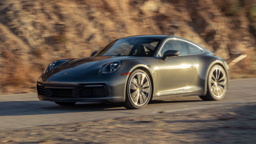

In [16]:
dest = 'porsche.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

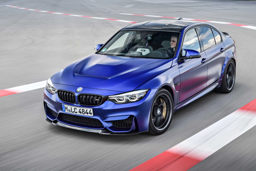

In [17]:
download_url(search_images('2020 BMW M3 Photos', max_images=1)[0], 'bmw.jpg', show_progress=False)
Image.open('bmw.jpg').to_thumb(256,256)

In [18]:
searches = '2020 BMW M3', '2020 Porsche 911'

In [19]:
path = Path('2020_porsche_911_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(2)
    resize_images(path/o, max_size=400, dest=path/o)


In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

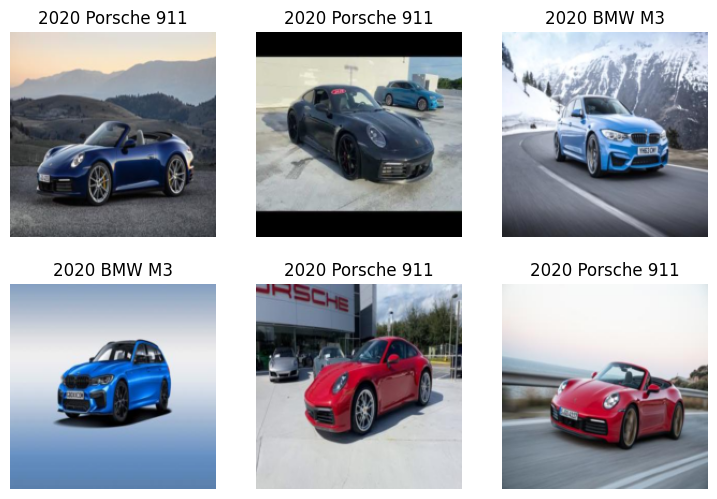

In [46]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

In [47]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.991518,0.362424,0.896552,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.506580,0.359328,0.879310,00:00
1,0.387039,0.366856,0.896552,00:00
2,0.282251,0.305527,0.913793,00:00
3,0.204819,0.472478,0.913793,00:00
4,0.162006,0.559926,0.896552,00:00
5,0.126842,0.557308,0.896552,00:00
6,0.102558,0.526070,0.913793,00:00
7,0.085019,0.515678,0.931035,00:00
8,0.080544,0.505752,0.931035,00:00
9,0.069566,0.501830,0.931035,00:00


In [31]:
is_porsche,_,probs = learn.predict(PILImage.create('porsche.jpg'))
print(f"This is a: {is_porsche}.")
print(f"Probability this is a Porsche: {probs[0]:.4f}")

This is a: 2020 Porsche 911.
Probability this is a Porsche: 0.0000


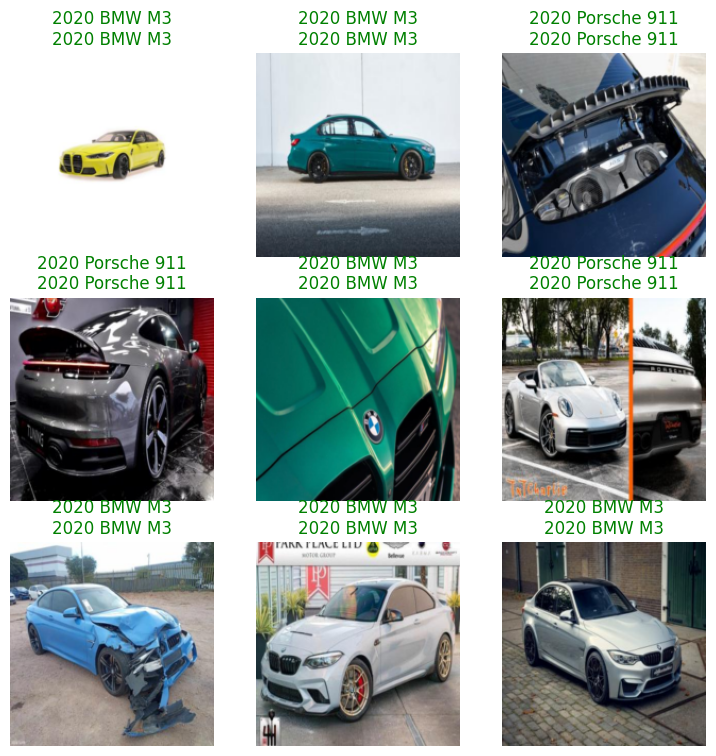

In [49]:
learn.show_results()

In [50]:
learn.export("porschebmw93.pkl")